# First, scrape the channel id that is going to be scraped

1528 channels found on channelCrowler after filtering with:
1. catergory: Howto & &
2. subscribers > 1,000
3. total videos > 100
4. keyword: makeup

(20 channels per page, ~ 77 pages)

note: only 1471 channels are actually scraped

In [12]:
####################################################################
######### Prepare the links of all perfumes to be scrapped #########
####################################################################

import sys
import re  # regular expression operations
import csv
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup          # use beautifulsoup library to scrape web
from time import sleep # be nice

def make_soup(url):
    hdr = {'User-Agent': 'Mozilla/5.0'} 
    req = urllib.request.Request(url,headers=hdr)
    page = urlopen(req).read()
    return BeautifulSoup(page, "lxml")

def get_channel_links(soup):
    #divs = soup.find_all("h4")
    divs = soup.find_all("div", {"class":"span3"})
    links = []
    count = 0
    for div in divs:
        try:
            links.append(div.find("a")["href"])
            count = count + 1
        except TypeError:
            print ("Cannot find channel link here")
    print(count)
    return links

if __name__ == '__main__':

    # prepare the web links of all pages
    #BASE_page = "http://www.channelcrawler.com/results/58069/page:"
    BASE_page = "http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:" # sorted by videos
    channel_pages = []  # the links of all 77 pages, each contains 20 channel links
    for i in range(1, 78):
        channel_pages.append(BASE_page + str(i))
    
    # obtain the perfume links from each group
    channel_links = []
    for page in channel_pages:
        print (page)
        soup_page = make_soup(page)
        links = get_channel_links(soup_page)
        channel_links = channel_links + links
    print ("Finish fetching all channel links")

http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:1
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:2
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:3
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:4
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:5
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:6
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:7
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:8
1
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:9
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:10
20
http://www.channelcrawler.com/results/58069/sort:Channel.videos/direction:asc/page:11
20
http://www.channelcrawler.com/r

In [2]:
len(channel_links)

1488

In [6]:
channel_links[1380]

'http://www.youtube.com/channel/UC2Mk_MBvikQkU4yl0J5VoJg'

In [6]:
channel_links[:10]

['http://www.youtube.com/channel/UCaezsZGhwWgB4ZRmHNCfIyw',
 'http://www.youtube.com/channel/UC2v8a2K3PtXfmlcpseWkzew',
 'http://www.youtube.com/channel/UCkDc40NlwHtmq8udJKYMuMA',
 'http://www.youtube.com/channel/UCXMO7JjiR6NXc2YC95wAH9Q',
 'http://www.youtube.com/channel/UCEWatJSQffXadyNAExPaOvw',
 'http://www.youtube.com/channel/UCXFtdw-ICkVzvZeBJSiiYoA',
 'http://www.youtube.com/channel/UC6K4R3UtPSrTQBQPV_I6xJQ',
 'http://www.youtube.com/channel/UCW13GdAD2VzHooCuc8Kjq8A',
 'http://www.youtube.com/channel/UCmPY1lZrQ-xyiREad99ZQXw',
 'http://www.youtube.com/channel/UCOedsFQ4mpPy4zTx9-cKugw']

In [3]:
x_id = "UCUSV0-kNMyQGIDol_468KpA"
x_url = "http://www.youtube.com/channel/" + x_id
x_index = channel_links.index(x_url)
print ("The index of channel-{0} is {1}".format(x_id, x_index))

The index of channel-UCUSV0-kNMyQGIDol_468KpA is 1334


# Next, use selenium to scrape all the videos from each channel

features to be scraped:
1. channel id
2. channel subscriptions
3. number of videos 
4. video id  (--> to retrive thumbnail images)
5. video views
6. video title 
7. video published date (--> to convert later)

using video id to get the thumbnail image
1. http://img.youtube.com/vi/1Jyy4zBiPiQ/mqdefault.jpg # median quality
2. https://i.ytimg.com/vi/1Jyy4zBiPiQ/hqdefault.jpg  # high quality
3. http://img.youtube.com/vi/1Jyy4zBiPiQ/0.jpg  # default

In [1]:
############################
# connect to sqlite
import sqlite3
conn = sqlite3.connect('youtube_project.db') # connection
c = conn.cursor() # cursor

In [6]:
# create a table (videos_beauty) to store: 
# 1. channel id
# 2. channel subscriptions
# 3. number of videos belonging to the channel 
# 4. video id (PRIMARY KEY)
# 5. video views
# 6. video title
# 7. video published at date

#c.execute('CREATE TABLE videos_beauty (channel_id TEXT, subscriptions_count INTEGER, videos_count INTEGER, video_id TEXT PRIMARY KEY, video_views INTEGER, video_title TEXT, video_date TEXT)')
#conn.commit()

In [5]:
import time

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
import selenium.webdriver.support.ui as ui
from selenium.webdriver.support.wait import WebDriverWait

browser = webdriver.Chrome(executable_path="/Users/yaoli/02_JobApplications/03_DataScience/insight/project/youtube/chromedriver")

In [11]:
############################
# loop over lover 1K channels

chan_start = "channel/"

for chan in channel_links[1355:1356]:
    sleep(0.5)
    print("Channel index is {0}.".format(channel_links.index(chan)))
    
    ##########################
    # find channel id from url
    channel_id = chan[chan.index(chan_start) + len(chan_start):]
    #print(channel_id)
    
    #######################################################
    # open a web page in the browser (replace the old page)
    browser.get(chan + "/videos")
    sleep(0.2)
    
    #######################
    # find subscriber count
    wait=ui.WebDriverWait(browser,100)
    subscriber_xpath = '//*[@id="c4-primary-header-contents"]/div/div/div[2]/div/span/span[1]'
    #wait.until(EC.visibility_of_element_located((By.XPATH,subscriber_xpath)))
    #subscriber = int(browser.find_element_by_xpath(subscriber_xpath).text.replace(',' , ''))
    try:
        wait.until(EC.visibility_of_element_located((By.XPATH,subscriber_xpath)))
        subscriber = int(browser.find_element_by_xpath(subscriber_xpath).text.replace(',' , ''))
    except TimeoutException:   
        continue
    
    print ("This channel has {0} subscribers.".format(subscriber))
    
    ###########################################
    # load all videos belonging to this channel
    i = 0
    try:
        while True:
            browser.find_element_by_css_selector("span.load-more-text").click()
            sleep(2)
            i = i + 1
            # if the channel has more than 420 videos, drop it. or it takes too many times to load the page
            if i > 23:
                break
            print("Page: {0}".format(i))
    except NoSuchElementException:   
        pass
    print("Done loading this channel page")
    
    #############################################
    # compute number of videos
    video_count = len(browser.find_elements_by_class_name('yt-lockup-title'))  # number of videos
    print("This channel has {0} videos.".format(video_count))
    
    ###################################
    # find vidoe id, views, title, date
    ###################################
    for j in range(video_count):
        print("Video {0}".format(j + 1))
        
        ################
        # find video id
        videoID_start = '//*[@id="channels-browse-content-grid"]/li['
        videoID_end = ']/div'
        videoID_xpath = videoID_start + str(j+1) + videoID_end

        videoID = browser.find_element_by_xpath(videoID_xpath).get_attribute('data-context-item-id')

        ##################
        # find video views
        views_start = '//*[@id="channels-browse-content-grid"]/li['
        views_end = ']/div/div[1]/div[2]/div/ul/li[1]'
        views_xpath = views_start + str(j+1) + views_end

        views = ''
        for digit in filter(str.isdigit, browser.find_element_by_xpath(views_xpath).text):
            views = views + str(digit)
        views = int(views)
        #print ("This videos has {0} views.".format(views))

        ##################
        # find video title
        title_start = '//*[@id="channels-browse-content-grid"]/li['
        title_end = ']/div/div[1]/div[2]/h3/a'
        title_xpath = title_start + str(j+1) + title_end

        title = browser.find_element_by_xpath(title_xpath).get_attribute('title')
        #print(title)

        ##################
        # find video date
        date_start = '//*[@id="channels-browse-content-grid"]/li['
        date_end = ']/div/div[1]/div[2]/div/ul/li[2]'
        date_xpath = date_start + str(j+1) + date_end
        #date = browser.find_element_by_xpath(date_xpath).text
        #print(date)
        try:
            date = browser.find_element_by_xpath(date_xpath).text
        except NoSuchElementException:   
            pass  # video_count may not be the number of videos scraped
        

        #############################
        # save this video information
        #c.execute('CREATE TABLE videos_beauty (channel_id, subscriptions_count, videos_count, video_id, video_views, video_title, video_date)')
        c.execute("INSERT OR IGNORE INTO videos_beauty(channel_id, subscriptions_count, videos_count, video_id, video_views, video_title, video_date) VALUES(?, ?, ?, ?, ?, ?, ?)", (channel_id, subscriber, video_count, videoID, views, title, date))
        conn.commit()
        #sleep(0.1)
        
print("Done scraping these videos.")


Channel index is 1355.
This channel has 1931 subscribers.
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Done loading this channel page
This channel has 537 videos.
Video 1
Video 2
Video 3
Video 4
Video 5
Video 6
Video 7
Video 8
Video 9
Video 10
Video 11
Video 12
Video 13
Video 14
Video 15
Video 16
Video 17
Video 18
Video 19
Video 20
Video 21
Video 22
Video 23
Video 24
Video 25
Video 26
Video 27
Video 28
Video 29
Video 30
Video 31
Video 32
Video 33
Video 34
Video 35
Video 36
Video 37
Video 38
Video 39
Video 40
Video 41
Video 42
Video 43
Video 44
Video 45
Video 46
Video 47
Video 48
Video 49
Video 50
Video 51
Video 52
Video 53
Video 54
Video 55
Video 56
Video 57
Video 58
Video 59
Video 60
Video 61
Video 62
Video 63
Video 64
Video 65
Video 66
Video 67
Video 68
Video 69
Video 70
Video 71
Video 72
Video 73
Video 74
Video 75
Video 76
Video 77


In [12]:
# Dont forget to close the connection
conn.close()

In [386]:
# drop/delete the table?
#c.execute('DROP TABLE videos_beauty')
#conn.commit()

In [2]:
##############################################
# find all channel ids, ordered alphabatically
channel_scraped = []  # save all the channel id got selected 
for row in c.execute('SELECT DISTINCT channel_id FROM videos_beauty ORDER BY channel_id'):
    channel_scraped.append(row[0])
len(channel_scraped)

1329

In [4]:
channel_scraped.index("UCpI5rhiiwbIj0ah5me3mwTw")

1098

In [3]:
channel_scraped[165]

'UC70nSbmj7J_y4snjTyDlaOg'

In [3]:
############################
# defind a function, given video id, retrive thumbnail image
import urllib.request
import os

def download_image(id_of_video):
    image_base_url_0 = "http://img.youtube.com/vi/"
    image_base_url_1 = "/mqdefault.jpg"
    myPath = "/Users/yaoli/02_JobApplications/03_DataScience/insight/project/youtube/thumnail_images/"
    image_url = image_base_url_0 + id_of_video + image_base_url_1
    fullfilename = myPath + id_of_video + ".jpg"
    # retrrive the image
    urllib.request.urlretrieve(image_url, fullfilename)
    return

In [6]:
###############################################
# download the images of videos for selected channel
import urllib.request
from time import sleep # be nice

for channel in channel_scraped[1250:]:
    print("Channel index is {0}".format(channel_scraped.index(channel)))
    for row in c.execute("SELECT COUNT(*) FROM videos_beauty WHERE channel_id = '{0}'".format(channel)):
        print ("Channel - {0} has {1} videos".format(channel, row[0]))
    print("Start downloading...".format(channel))
    #count = 0
    for row in c.execute("SELECT * FROM videos_beauty WHERE channel_id = '{0}'".format(channel)):
        video_id = row[3]
        #count = count + 1
        #print("Video: {0}, {1} ".format(count, video_id))
        try:
            download_image(video_id)
        except urllib.error.HTTPError as err:
            # remove this channel from list
            c.execute("DELETE FROM videos_beauty WHERE channel_id = '{0}'".format(channel)) 
            conn.commit()
            print ("Delete channel - {0}, its index is {1}".format(channel, channel_scraped.index(channel)))
            break
        #sleep(0.1)
    print("Done downloading video thumbnail images for this channel!")
print("Done downloading videos for these channels!")

Channel index is 1250
Channel - UCwSUr8JkGnW8C6nJYLdJOUA has 418 videos
Start downloading...
Delete channel - UCwSUr8JkGnW8C6nJYLdJOUA, its index is 1250
Done downloading video thumbnail images for this channel!
Channel index is 1251
Channel - UCwURXDe1jQ2jmj0TmTstmpg has 214 videos
Start downloading...
Delete channel - UCwURXDe1jQ2jmj0TmTstmpg, its index is 1251
Done downloading video thumbnail images for this channel!
Channel index is 1252
Channel - UCwWaiSALasQd9LxYu0zYmCA has 173 videos
Start downloading...
Done downloading video thumbnail images for this channel!
Channel index is 1253
Channel - UCwWcynx5Cr7JIl0kFODkS5g has 437 videos
Start downloading...
Done downloading video thumbnail images for this channel!
Channel index is 1254
Channel - UCwbQL-LZ4-CPWsJB4tTi4Rg has 350 videos
Start downloading...
Done downloading video thumbnail images for this channel!
Channel index is 1255
Channel - UCwca9otOCJNRkXaNsI7VsZg has 189 videos
Start downloading...
Done downloading video thumbna

# Extract features from images 
1. brightness (global)
2. dynamic range
3. Michelson contrast
4. RMS contrast

In [114]:
############################
# connect to sqlite
import sqlite3
conn = sqlite3.connect('youtube_project.db') # connection
c = conn.cursor() # cursor
c_1 = conn.cursor()
c_2 = conn.cursor()
c_3 = conn.cursor()
c_4 = conn.cursor()

In [14]:
# Add new columns to sqlite
#c.execute('ALTER TABLE videos_beauty ADD COLUMN brightness_global REAL dynamic_range REAL contrast_Mic REAL contrast_RMS REAL')
#c.execute('ALTER TABLE videos_beauty ADD COLUMN hue REAL saturation REAL')
#conn.commit()

In [115]:
##############################################
# find all channel ids, ordered alphabatically
channel_scraped = []  # save all the channel id got selected 
for row in c.execute('SELECT DISTINCT channel_id FROM videos_makeup ORDER BY channel_id'):
    channel_scraped.append(row[0])
len(channel_scraped)

1299

In [90]:
########################################################
# a function to compute global brightness, dynamic range, 
# Michelson contrast and RMS contrast
import cv2
import numpy as np

def compute_image_features_global(id_of_video):
    myPath = "/Users/yaoli/02_JobApplications/03_DataScience/insight/project/youtube/thumnail_images/"
    fullfilename = myPath + id_of_video + ".jpg"
    
    #####################################
    # use openCV compute 
    # global hue, saturation, birightness (value)
    # dynamic range, Michelson contrast and RMS contrast

    img = cv2.imread(fullfilename)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue = img_hsv.mean(axis=(0,1))[0]/179
    sat = img_hsv.mean(axis=(0,1))[1]/255
    bri_global = img_hsv.mean(axis=(0,1))[2]/255 # value = brightness
    #print("The global hue, saturation, brightness: ({0}, {1}, {2})".format(hue, sat, bri_global))

    bri = img_hsv[:, :, 2]/255 # matrix of all pixel, normalized

    ###############################################
    # compute Michelson contrast
    bri_max = bri.max()
    bri_min = bri.min()
    contrast_Mic = (bri_max - bri_min) / (bri_max + bri_min)
    #print("bri_max - {0}, bri_min - {1}, contrast_Mic -{2}".format(bri_max, bri_min, contrast_Mic))
    #print("The Michelson contrast of this image is {0}".format(contrast_Mic))

    # compute dynamic range
    dynamic_range = bri_max - bri_min
    #print("The dynamic range of this image is {0}".format(dynamic_range))

    # compute RMS contrast
    bri_norm = bri / bri_max # 1st, normalize the brightness matrix
    contrast_RMS = bri_norm.std(axis=(0,1))
    #print ("The RMS contrast of this image is {0}".format(contrast_RMS))
    
    return (hue, sat, bri_global, dynamic_range, contrast_Mic, contrast_RMS)

In [ ]:
video_id = 'eznOR7jl33U'

In [100]:
len(channel_scraped)

1326

In [102]:
########################
# add image-based features into database
from sqlite3 import OperationalError

count_delete = 0

for channel in channel_scraped[1300:]:
    print("Channel index is {0}".format(channel_scraped.index(channel)))
    for row in c_1.execute("SELECT COUNT(*) FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        print ("Channel - {0} has {1} videos".format(channel, row[0]))
    print("Start computing...")
    for row in c_2.execute("SELECT * FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        video_id = row[3]
        #print("video id - {0}".format(video_id))

        try:
            img_feature = compute_image_features_global(video_id)
        #except error:
        except Exception as e:
            c_4.execute("DELETE FROM videos_makeup WHERE channel_id = '{0}'".format(channel)) 
            conn.commit()
            count_delete = count_delete + 1
            print ("Delete channel - {0}, its index is {1}".format(channel, channel_scraped.index(channel)))
            break
        
        try:
            c_3.execute("UPDATE videos_makeup SET hue={0}, saturation={1}, brightness_global={2}, dynamic_range={3}, contrast_Mic={4}, contrast_RMS={5} WHERE video_id='{6}'".format(img_feature[0], img_feature[1], img_feature[2], img_feature[3], img_feature[4], img_feature[5], video_id))
            conn.commit()
        except OperationalError:
            # remove this channel from list
            c_4.execute("DELETE FROM videos_makeup WHERE channel_id = '{0}'".format(channel)) 
            conn.commit()
            count_delete = count_delete + 1
            print ("Delete channel - {0}, its index is {1}".format(channel, channel_scraped.index(channel)))
            break
            
    print("Done computing image-based features (global) for this channel!")
print("Done computing image-based features (global) for these channels!")
print("{0} channels are deleted.".format(count_delete))

Channel index is 1300
Channel - UCz4redHIoZ7_L8eZNFM3B5A has 119 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1301
Channel - UCz71kJLcrKwBVh_adAatZqA has 232 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1302
Channel - UCz7CjqAxoaLgWi72rIWAZpQ has 101 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1303
Channel - UCz85TkBve8Znz0M6u4f0gvg has 167 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1304
Channel - UCzAp19vQlEGSR-Z-u-TtvZQ has 144 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1305
Channel - UCzDvKmwQ6N9Z_PjuiLBspOQ has 344 videos
Start computing...
Done computing image-based features (global) for this channel!
Channel index is 1306
Channel - UCzEolHECo7JmmkWMGDYaSOA has 126 videos
Star

In [123]:
###############################
# add len_title into database

for channel in channel_scraped[1290:]:
    print("Channel index is {0}".format(channel_scraped.index(channel)))
    for row in c_1.execute("SELECT COUNT(*) FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        print ("Channel - {0} has {1} videos".format(channel, row[0]))
    print("Start computing...")
    for row in c_2.execute("SELECT * FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        video_id = row[3]
        #print("video id - {0}".format(video_id))
        title_len = len(row[5])
        #print("The length of title is: {0}".format(title_len))
        c_3.execute("UPDATE videos_makeup SET len_title={0} WHERE video_id='{1}'".format(title_len, video_id))
        conn.commit()

    print("Done computing title length for this channel!")
print("Done computing title length for these channels!")


Channel index is 1290
Channel - UCzT17-Lvc5L_gIT10JQsjSA has 229 videos
Start computing...
Done computing title length for this channel!
Channel index is 1291
Channel - UCzXtkiRsRbGvzO73XL3UGhQ has 196 videos
Start computing...
Done computing title length for this channel!
Channel index is 1292
Channel - UCzasQlBSuRXvzePW7-TY1AA has 114 videos
Start computing...
Done computing title length for this channel!
Channel index is 1293
Channel - UCzehSNfvLzNZBaDWl9gjisw has 228 videos
Start computing...
Done computing title length for this channel!
Channel index is 1294
Channel - UCzhVOSa-PI4kDVFPL8T5RHw has 336 videos
Start computing...
Done computing title length for this channel!
Channel index is 1295
Channel - UCzqyss12CyV4jZtrhpksF4Q has 264 videos
Start computing...
Done computing title length for this channel!
Channel index is 1296
Channel - UCztc5jP8v9Ht2mBLKYMmX_Q has 79 videos
Start computing...
Done computing title length for this channel!
Channel index is 1297
Channel - UCzxEXJ_ts

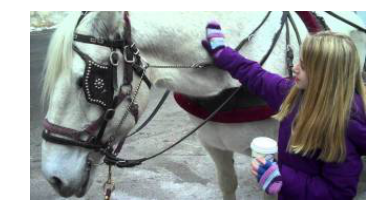

(<matplotlib.image.AxesImage at 0x1178efc50>, None)

In [107]:
##############################
# display the image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

id_of_video = 'fXb8wUrcjNk'
myPath = "/Users/yaoli/02_JobApplications/03_DataScience/insight/project/youtube/thumnail_images/"
fullfilename = myPath + id_of_video + ".jpg"
img = cv2.imread(fullfilename)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.show()

In [113]:
for row in c.execute("SELECT * FROM videos_makeup WHERE video_id = '{0}'".format("Ws42X57HbYc")):
    print(row)
    print(row[5])
    print(len(row[5]))
    print(type(row[5]))

('UCaezsZGhwWgB4ZRmHNCfIyw', 671404, 98, 'Ws42X57HbYc', 173886, 'Makeup Collection & Storage | Cruelty Free ♡', '4 months ago', 0.23080394553072628, 0.21126477396514162, 0.47054541122004356, 1.0, 1.0, 0.25009189120891473)
Makeup Collection & Storage | Cruelty Free ♡
44
<class 'str'>


# Compute regional features for images
1. ratio of background area to foreground area (ratio_bc_fr)
2. brightness of foreground (bri_fr_mean)
3. brightness of background (bri_bc_mean)
4. brightness difference of background and foreground (bri_diff_mean)
5. standard deviation of brightness for background / contrast for background / uniformity of background (contrast_bc)
6. standard deviation of brightness for foreground --> contrast for foregournd (contrast_fr)
7. contrast difference of background and foreground (contrast_diff)
8. compute saturation/colorfulness for background (sat_bc)

In [1]:
############################
# connect to sqlite
import sqlite3
conn = sqlite3.connect('youtube_project.db') # connection
c = conn.cursor() # cursor
c_1 = conn.cursor()
c_2 = conn.cursor()
c_3 = conn.cursor()
c_4 = conn.cursor()

In [9]:
##############################################
# find all channel ids, ordered alphabatically
channel_scraped = []  # save all the channel id got selected 
for row in c.execute('SELECT DISTINCT channel_id FROM videos_makeup ORDER BY channel_id'):
    channel_scraped.append(row[0])
len(channel_scraped)

1221

In [3]:
channel_scraped.index("UC_wSh-TgEdfQBswAJR97mVA")

726

In [7]:
######################################
# openCV: cut foreground from background
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
%matplotlib inline

myPath = "/Users/yaoli/02_JobApplications/03_DataScience/insight/project/youtube/thumnail_images/"
count_delete = 0

for channel in channel_scraped[900:]:
    print("Channel index is {0}".format(channel_scraped.index(channel)))
    for row in c_1.execute("SELECT COUNT(*) FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        print ("Channel - {0} has {1} videos".format(channel, row[0]))
    print("Start computing...")
    for row in c_2.execute("SELECT * FROM videos_makeup WHERE channel_id = '{0}'".format(channel)):
        #print(row[-1])
        video_id = row[3]
        fullfilename = myPath + video_id + ".jpg"
        img = cv2.imread(fullfilename)
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        #rect = (50,50,450,290)
        rect = (10,10,450,290)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        #plt.axis("off")
        #plt.imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)),plt.show()

        ###############################################
        # obtain the mask of foreground, and background
        mask_fr = mask2 # background: 0, foreground: 1
        mask_bc = np.ones(img.shape[:2],np.uint8) - mask_fr # background: 1, foreground: 0

        img_fr = img*mask_fr[:,:,np.newaxis]
        img_bc = img*mask_bc[:,:,np.newaxis]

        ###############################################
        # ratio of background area to foreground area
        area_fr = np.count_nonzero(mask2 == 1) 
        area_bc = np.count_nonzero(mask2 == 0) 
        area_total = area_fr + area_bc
        #print("The ratio of background area to foreground area is {0}".format(ratio_bc_fr))
        
        try:
            ratio_bc_fr = area_bc / area_fr
        except ZeroDivisionError:
            # remove this channel from list
            c_4.execute("DELETE FROM videos_makeup WHERE channel_id = '{0}'".format(channel)) 
            conn.commit()
            count_delete = count_delete + 1
            print ("Delete channel - {0}, its index is {1}".format(channel, channel_scraped.index(channel)))
            break

        ###############################################
        # compute regional features
        # compute brightness of background and foreground

        # brightness of foreground
        img_fr_hsv = cv2.cvtColor(img_fr, cv2.COLOR_BGR2HSV)
        bri_fr_mean = img_fr_hsv.mean(axis=(0,1))[2] * area_total / area_fr /255

        # brightness of background
        img_bc_hsv = cv2.cvtColor(img_bc, cv2.COLOR_BGR2HSV)
        bri_bc_mean = img_bc_hsv.mean(axis=(0,1))[2] * area_total / area_bc /255

        # brightness difference of background and foreground
        bri_diff_mean = bri_fr_mean - bri_bc_mean

        # compute standard deviation of brightness for background --> contrast for background / uniformity of background
        bri_bc = img_bc_hsv[:, :, 2] /255
        x = bri_bc - np.multiply(np.full(bri_bc.shape, bri_bc_mean), mask_bc)
        contrast_bc = math.sqrt(np.sum(np.multiply(x, x)) / area_bc)

        # compute standard deviation of brightness for foreground --> contrast for foregournd
        bri_fr = img_fr_hsv[:, :, 2] /255
        x = bri_fr - np.multiply(np.full(bri_fr.shape, bri_fr_mean), mask_fr)
        contrast_fr = math.sqrt(np.sum(np.multiply(x, x)) / area_fr)

        # contrast difference of background and foreground
        contrast_diff = contrast_fr - contrast_bc

        # compute saturation/colorfulness for background
        sat_bc = img_bc_hsv.mean(axis=(0,1))[1] * area_total / area_bc /255
        
        c_3.execute("UPDATE videos_makeup SET ratio_bc_fr={0}, bri_fr_mean={1}, bri_bc_mean={2}, bri_diff_mean={3}, contrast_bc={4}, contrast_fr={5}, contrast_diff={6}, sat_bc={7} WHERE video_id='{8}'".format(ratio_bc_fr, bri_fr_mean, bri_bc_mean, bri_diff_mean, contrast_bc, contrast_fr, contrast_diff, sat_bc, video_id))
        conn.commit()
    print("Done computing regional features for this channel!")
print("Done computing regional features for these channels!")
print("Done computing regional features for these channels!")
print("Done computing regional features for these channels!")

Channel index is 900
Channel - UCjLx42uF3d1TLPJ21pHyr9A has 212 videos
Start computing...
Done computing regional features for this channel!
Channel index is 901
Channel - UCjPCcvx0Bod3FcUZ14QqpIg has 326 videos
Start computing...
Done computing regional features for this channel!
Channel index is 902
Channel - UCjRpxZQ06QoRgGzD4KSg02g has 285 videos
Start computing...
Done computing regional features for this channel!
Channel index is 903
Channel - UCjU4mmVjdxIPX6TU4fth2hw has 118 videos
Start computing...
Done computing regional features for this channel!
Channel index is 904
Channel - UCjUSijOSGu-i5ReyT26QwzA has 139 videos
Start computing...
Done computing regional features for this channel!
Channel index is 905
Channel - UCjVoaYKOw7XIarKpWItAe0Q has 126 videos
Start computing...
Done computing regional features for this channel!
Channel index is 906
Channel - UCjYDZYxCMhck-JMAN2tpplg has 449 videos
Start computing...
Delete channel - UCjYDZYxCMhck-JMAN2tpplg, its index is 906
Done

Stop at channel - "UCFSb_tOQQJtBJsOiakWqhgQ", index - 349 (done)

In [8]:
count_delete

23

In [132]:
conn.close

<function Connection.close>